# Fraud Detection
- Data is highly imbalanced
- Interval_after_signup and time related raw and aggregates are highly predictive of fraud
- Made actionable operation recommendations/proposal for business

# Part 0: Setup enviornment and load data

In [1]:
# install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
!pip install XGBOOST

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# import library and model

# Data manipulation library
import pandas as pd
import numpy as np

# Visulization
%matplotlib notebook
%matplotlib inline
import time
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import plotly.graph_objects as go
import matplotlib.pylab as pylab
import plotly.express as px

# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import keras
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

# Model support function
from sklearn.ensemble import IsolationForest
from sklearn import metrics
from sklearn.metrics import roc_curve, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer 
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, learning_curve, validation_curve, cross_val_score
from scipy.stats import iqr
from scipy import stats

# Feature analysis
from sklearn.inspection import permutation_importance
!pip install shap
import shap
shap.initjs()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 2.8 MB/s 


In [4]:
!pip install -U imbalanced-learn
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
# put this in the beginning. It will not generate bug if this code is in the beginning.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 5.3 MB/s 
     |████████████████████████████████| 199 kB 54.7 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     / 21.9 MB 141 kB/s
     |████████████████████████████████| 102 kB 4.7 MB/s 
     |████████████████████████████████| 690 kB 42.1 MB/s 
     |████████████████████████████████| 4.7 MB 40.4 MB/s 
     |████████████████████████████████| 62 kB 670 kB/s 
     |████████████████████████████████| 812 kB 44.2 MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.2.0-py2.py3-none-any.whl size=261257 sha256=e45aa34056a5fc21dfc2c07a3dad5ef8a7565db5298618e2a0c5690e43c0809e
  Stored in directory: /tmp/pip-ephem-wheel-cache-4smd6cf3/wheels/cc/d5/09/083fb07c9363a2f45854b0e3a7de7d7c560f07da74b9e9769d
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=688428c2305401c87338888c45bf370d24f6c3bb2b8e4bc3a895c42f9105b809
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash

In [5]:
# Setup display of rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 6)

# Setup default figure properties
sns.set()
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 16,
         'axes.titlesize':'x-large',
         'xtick.labelsize':12,
         'ytick.labelsize':12}
pylab.rcParams.update(params)
plt.rc('font', size=14) 
plt.rc('legend', fontsize=12)

In [6]:
# load data from google drive
id1 = "1eeaSUFnTxFJKlIFURm-1LYfcX7PlO4vh"
file1 = drive.CreateFile({'id':id1}) 
file1.GetContentFile('ipToCountry')

id2 = "1XX5ck8p14ErvkZDsub-gKYuQKpsSStzn"
file2 = drive.CreateFile({'id':id2}) 
file2.GetContentFile('fraud_data')

ipToCountry = pd.read_csv('ipToCountry')
fraud_data = pd.read_csv('fraud_data')

# Part 1: Exploratory Data Analysis

In [7]:
!cd fraudDetection/
!ls fraudDetection/
!pip install -U imbalanced-learn
# !pip install pandas-profiling
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

/bin/bash: line 0: cd: fraudDetection/: No such file or directory
ls: cannot access 'fraudDetection/': No such file or directory
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


## Part 1.1 Understanding the Raw Dataset

### part 1.1.1: Type of variables

In [8]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0


In [9]:
ipToCountry.head(5)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [10]:
# data shape of fruad_data
print("The fraud dataset has {} rows.".format(fraud_data.shape[0]))
print("The fraud dataset has {} columns.".format(fraud_data.shape[1]))

The fraud dataset has 138376 rows.
The fraud dataset has 11 columns.


In [11]:
# data shape of of ipToCountry
print("The ip_country dataset has {} rows.".format(ipToCountry.shape[0]))
print("The ip_country dataset has {} columns.".format(ipToCountry.shape[1]))

The ip_country dataset has 138846 rows.
The ip_country dataset has 3 columns.


In [12]:
# check fraud_data info
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138376 entries, 0 to 138375
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         138376 non-null  int64  
 1   signup_time     138376 non-null  object 
 2   purchase_time   138376 non-null  object 
 3   purchase_value  138376 non-null  int64  
 4   device_id       138376 non-null  object 
 5   source          138376 non-null  object 
 6   browser         138376 non-null  object 
 7   sex             138376 non-null  object 
 8   age             138376 non-null  int64  
 9   ip_address      138376 non-null  float64
 10  class           138376 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 11.6+ MB


In [13]:
# check the unique values of each column in fraud_data
fraud_data.nunique()

user_id          138376
signup_time      138376
purchase_time    137985
                  ...  
age                  58
ip_address       137653
class                 2
Length: 11, dtype: int64

### Part 1.1.2 Checking missing value

In [14]:
# check missing values in fraud_data
fraud_data.isna().sum().sort_values(ascending = False)

user_id          0
signup_time      0
purchase_time    0
                ..
age              0
ip_address       0
class            0
Length: 11, dtype: int64

In [15]:
# check ipToCountry info
ipToCountry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [16]:
# check missing valuesn in ipToCountry 
ipToCountry.isna().sum().sort_values(ascending = False)

lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64

In [17]:
# check duplicate in fraud_data
duplicateRow = fraud_data[fraud_data.duplicated()]

print("There are {} duplicated records in fraud_data.".format(duplicateRow.shape[0]))

There are 0 duplicated records in fraud_data.


### Part 1.1.3 Checking duplicate

In [18]:
# check duplicate in ipToCountry
duplicateRow = ipToCountry[ipToCountry.duplicated()]

print("There are {} duplicated records in fraud_data.".format(duplicateRow.shape[0]))

There are 0 duplicated records in fraud_data.


In [19]:
# check the balance of non-fraud and fraud
fraud_data.loc[:, ['class']].value_counts()

print("There are total {} records in fraud_data.".format(fraud_data.shape[0]))
print("There are total {} fraud records in fraud_data.".format(fraud_data[fraud_data['class']==0].shape[0]))
print("There are total {} fraud records in fraud_data.".format(fraud_data[fraud_data['class']==1].shape[0]))

There are total 138376 records in fraud_data.
There are total 136961 fraud records in fraud_data.
There are total 1415 fraud records in fraud_data.


Summary:


*   There are 138,376 records in fraud dataset, 138846 records in ipToCountry dataset.
*   There are no missing and duplicated data in both fraud dataset and ipToCountry dataset.
*   Fraud dataset has 7 columns categorical type and 10 numeric type.
*   Output: class in fraud dataset.





## 1.2 Understanding the features

### 1.2.1 Purchase and age

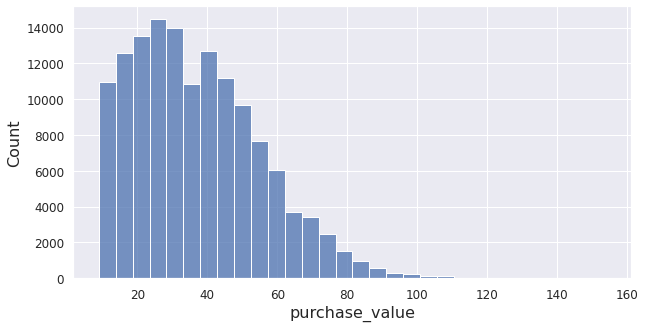

In [20]:
# Fig showing the total number of purchase based on purchase value.
plt.figure(figsize = (10,5))
sns.histplot(data = fraud_data[fraud_data['class'] == 0], x = 'purchase_value', bins = 30)

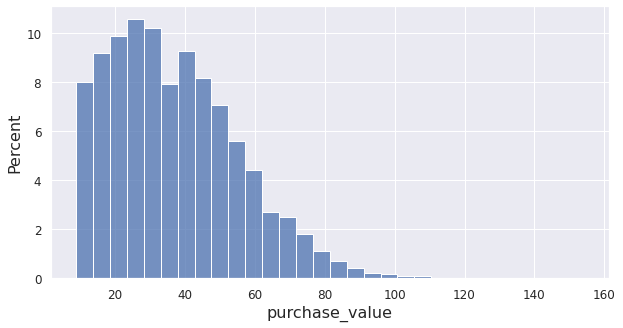

In [21]:
# Fig showing the percentage of purchase based on purchase value.
plt.figure(figsize = (10,5))
a = sns.histplot(data = fraud_data[fraud_data['class'] == 0], x = 'purchase_value', stat='percent', bins = 30)

Most purchase is under $50.

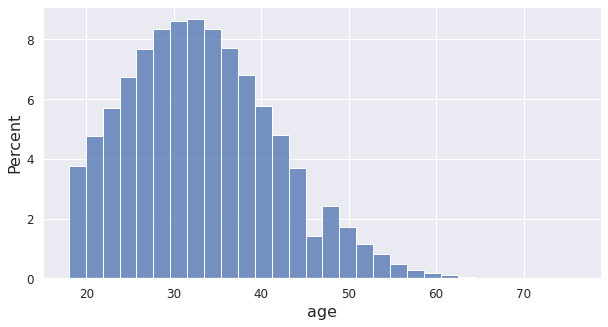

In [22]:
# Fig showing the percentage of purchase according to the age of customers.
plt.figure(figsize = (10,5))
sns.histplot(data = fraud_data[fraud_data['class'] == 0], stat='percent', x = 'age', bins = 30)

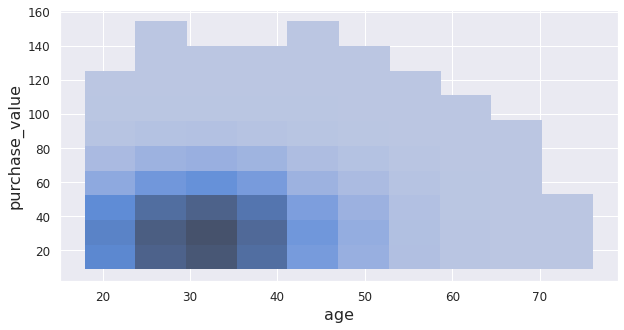

In [23]:
# check the purchase value according to the age of customers.
plt.figure(figsize = (10,5))
sns.histplot(x='age', y = 'purchase_value', bins = 10, data=fraud_data[fraud_data['class'] == 0])

Summary of the impact of age on purchase:

*   Customers between 25- and 40-year-old buy more and spend more for each order than other customers.



### 1.2.2 Purchase and gender

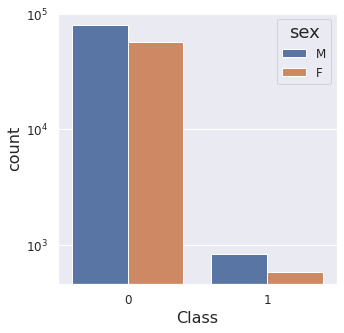

In [24]:
# Fig showing the total number of purchase according to the gender of customers.
plt.figure(figsize = (5,5))
sex_purchase_count = sns.countplot(x = 'class', hue = 'sex', data = fraud_data)
plt.setp(sex_purchase_count.get_legend().get_title(), fontsize='18') 

sex_purchase_count.set_yscale("log")
_ = sex_purchase_count.set(xlabel="Class")

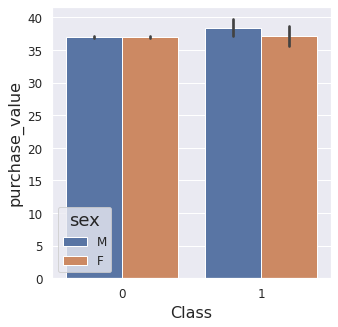

In [25]:
# Fig showing the average value of purchase according to the gender of customers.
plt.figure(figsize = (5,5))
sex_purchase_value = sns.barplot(x = 'class', y='purchase_value', hue = 'sex', data = fraud_data)
plt.setp(sex_purchase_value.get_legend().get_title(), fontsize='18') 

_ = sex_purchase_value.set(xlabel="Class")

In [122]:
fraud_data['purchase_value'].median()

35.0

Summary of the impact of gender on purchase:


*   Gender has no obvious impact on shopping behaviours.




### 1.2.3 Purchase and order source

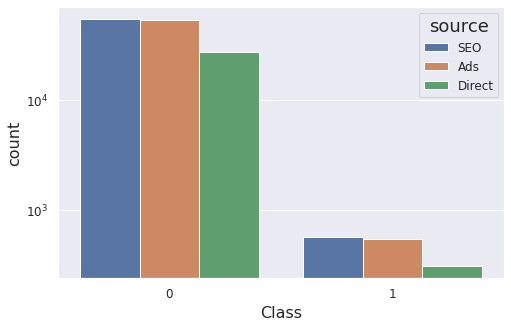

In [26]:
# Fig showing the total number of purchase according to source.
plt.figure(figsize = (8,5))
source_purchase_count = sns.countplot(x = 'class', hue = 'source', data = fraud_data)
plt.setp(source_purchase_count.get_legend().get_title(), fontsize='18') 
source_purchase_count.set_yscale("log")
_ = source_purchase_count.set(xlabel="Class")

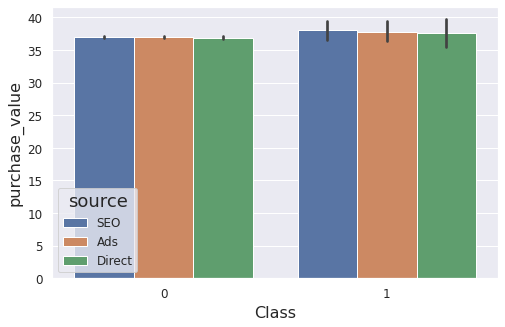

In [27]:
# Fig showing the total number of purchase according to source.
plt.figure(figsize = (8,5))
source_purchase_value = sns.barplot(x = 'class', y='purchase_value', hue = 'source', data = fraud_data)
plt.setp(source_purchase_value.get_legend().get_title(), fontsize='18') 
_ = source_purchase_value.set(xlabel="Class")

In [28]:
source_fault_percent = fraud_data.groupby(['source','class']).size().reset_index(name='count')
source_fault_percent

,source,class,count
0,Ads,0,54368
1,Ads,1,545
2,Direct,0,27390
3,Direct,1,307
4,SEO,0,55203
5,SEO,1,563


In [29]:
source_fault_percent['percent'] = (source_fault_percent['count'] / source_fault_percent.groupby('source')['count'].transform('sum'))*100
source_fault_percent

,source,class,count,percent
0,Ads,0,54368,99.007521
1,Ads,1,545,0.992479
2,Direct,0,27390,98.891577
3,Direct,1,307,1.108423
4,SEO,0,55203,98.990424
5,SEO,1,563,1.009576


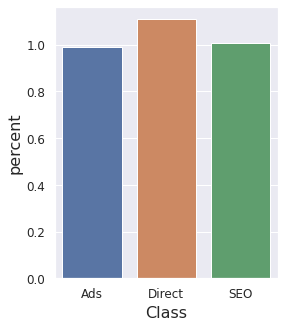

In [30]:
# Fig showing the total number of purchase according to source.
plt.figure(figsize = (4,5))
source_fault_per = sns.barplot(x = 'source', y='percent', data = source_fault_percent[source_fault_percent['class']==1])
_ = source_fault_per.set(xlabel="Class")

In [31]:
source_fault_percent2 = fraud_data[fraud_data['class']==1].groupby(['source']).size().reset_index(name='count')
source_fault_percent2['percent'] = (source_fault_percent2['count'] / sum(source_fault_percent2['count']))*100
source_fault_percent2

,source,count,percent
0,Ads,545,38.515901
1,Direct,307,21.696113
2,SEO,563,39.787986


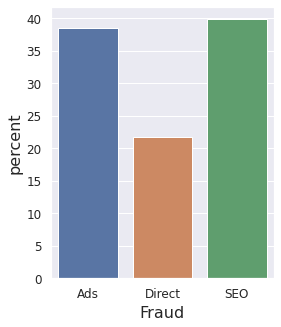

In [32]:
# Fig showing the total number of purchase according to source.
plt.figure(figsize = (4,5))
source_fault_per2 = sns.barplot(x = 'source', y='percent', data = source_fault_percent2)
_ = source_fault_per2.set(xlabel="Fraud")

Summary of the impact of order source on purchase:


*   The source of order has no impact on the value of single order.
*   The probability of fraud of direct order is higher than that of orders through Ads and SEO. 
*   Most fraud orders come from ads and seo order. 

### 1.2.4 Purchase and browser

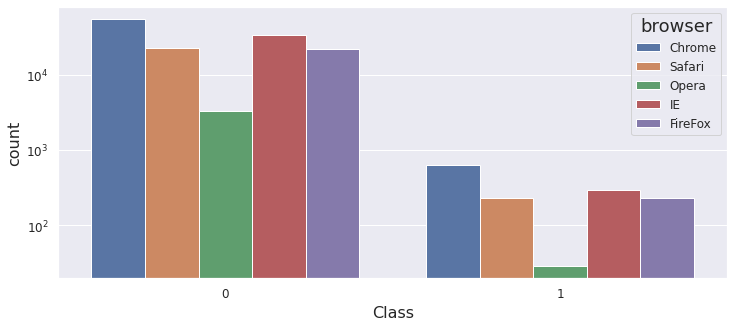

In [33]:
# Fig showing the average value of purchase according to the gender of customers.
plt.figure(figsize = (12,5))
browser_purchase_count = sns.countplot(x = 'class', hue = 'browser', data = fraud_data)
plt.setp(browser_purchase_count.get_legend().get_title(), fontsize='18') 

browser_purchase_count.set_yscale("log")
_ = browser_purchase_count.set(xlabel="Class")

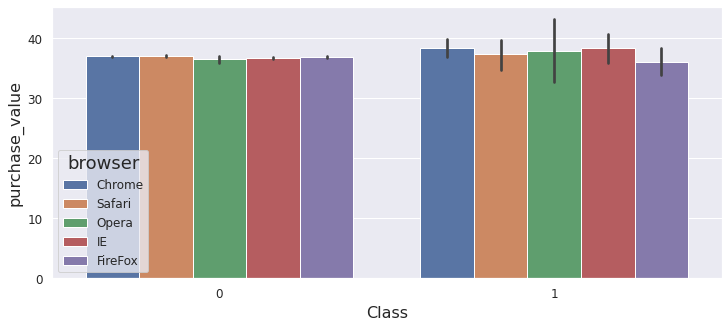

In [34]:
# Fig showing the average value of purchase according to the gender of customers.
plt.figure(figsize = (12,5))
browser_purchase_value = sns.barplot(x = 'class', y='purchase_value', hue = 'browser', data = fraud_data)
plt.setp(browser_purchase_value.get_legend().get_title(), fontsize='18') 

_ = browser_purchase_value.set(xlabel="Class")

In [35]:
browser_fault_percent = fraud_data.groupby(['browser','class']).size().reset_index(name='count')
browser_fault_percent

,browser,class,count
0,Chrome,0,55363
1,Chrome,1,630
2,FireFox,0,22268
...,...,...,...
7,Opera,1,29
8,Safari,0,22442
9,Safari,1,228


In [36]:
browser_fault_percent['percent'] = (browser_fault_percent['count'] / browser_fault_percent.groupby('browser')['count'].transform('sum'))*100
browser_fault_percent

,browser,class,count,percent
0,Chrome,0,55363,98.874859
1,Chrome,1,630,1.125141
2,FireFox,0,22268,98.968889
...,...,...,...,...
7,Opera,1,29,0.858750
8,Safari,0,22442,98.994266
9,Safari,1,228,1.005734


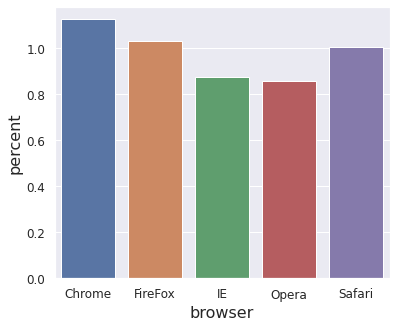

In [37]:
# Fig showing the total number of purchase according to source.
plt.figure(figsize = (6,5))
browser_fault_per = sns.barplot(x = 'browser', y='percent', data = browser_fault_percent[browser_fault_percent['class']==1])
_ = source_fault_per.set(xlabel="Browser")

In [38]:
source_browser_percent2 = fraud_data[fraud_data['class']==1].groupby(['browser']).size().reset_index(name='count')
source_browser_percent2['percent'] = (source_browser_percent2['count'] / sum(source_browser_percent2['count']))*100
source_browser_percent2

,browser,count,percent
0,Chrome,630,44.522968
1,FireFox,232,16.395760
2,IE,296,20.918728
3,Opera,29,2.049470
4,Safari,228,16.113074


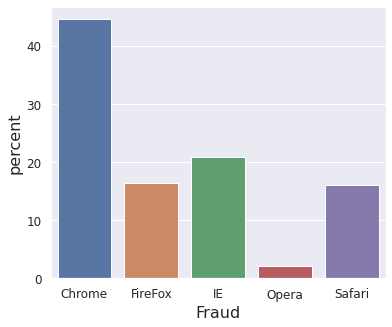

In [39]:
# Fig showing the total number of purchase according to source.
plt.figure(figsize = (6,5))
source_browser_per2 = sns.barplot(x = 'browser', y='percent', data = source_browser_percent2)
_ = source_browser_per2.set(xlabel="Fraud")

Summary of the impact of browser on purchase:



*   The browser of order has no impact on the value of single order. 
*   The probability of fraud of order from Chrome is higher, while the probability of fruad of order from IE and Opera is lower than that of other orders.
*    Most fraud orders come from chrome browser.

## 1.3 Distribution and correlation of variables


### 1.3.1 Describution of variables

In [40]:
# basic statistical details of the dataset

fraud_data_describe = fraud_data.describe()
fraud_data_describe.loc['var'] = fraud_data.var(numeric_only=True).tolist()
fraud_data_describe.loc['skew'] = fraud_data.skew(numeric_only=True).tolist()
fraud_data_describe.loc['kurt'] = fraud_data.kurtosis(numeric_only=True).tolist()
fraud_data_describe.transpose()

,count,mean,std,min,25%,50%,75%,max,var,skew,kurt
user_id,138376.0,2.001490e+05,1.152268e+05,2.000000,1.008948e+05,2.000005e+05,2.997452e+05,4.000000e+05,1.327721e+10,0.000413,-1.194544
purchase_value,138376.0,3.693899e+01,1.832109e+01,9.000000,2.200000e+01,3.500000e+01,4.900000e+01,1.540000e+02,3.356624e+02,0.675993,0.160211
age,138376.0,3.312587e+01,8.623645e+00,18.000000,2.700000e+01,3.300000e+01,3.900000e+01,7.600000e+01,7.436725e+01,0.427295,-0.177732
ip_address,138376.0,2.154381e+09,1.250563e+09,52093.496895,1.085079e+09,2.156471e+09,3.249150e+09,4.294850e+09,1.563908e+18,-0.007369,-1.214837
class,138376.0,1.022576e-02,1.006045e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.012127e-02,9.736766,92.805954


We could see all variables have skew and asimetric form. We'll see that with follow general plot in Part 1.3.2.

### Part 1.3.2 Distribution of neumeric variables

Text(0.5, 0.98, '\nDistribution of variable numericas')

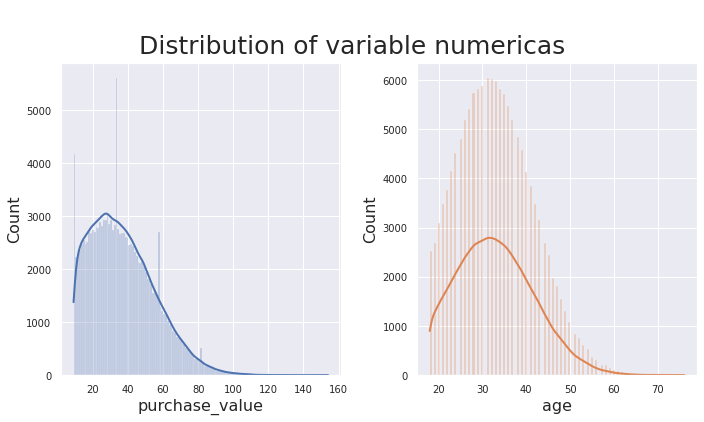

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axes = axes.flat
columnas_numeric = ['purchase_value', 'age']

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = fraud_data,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].tick_params(labelsize = 10)
    
fig.tight_layout()
plt.subplots_adjust(top = 0.85)
fig.suptitle('\nDistribution of variable numericas', fontsize = 25)

As we can see, the purchase value do not follow a normal distribution but show skewness. Therefore, they are not symmetric either.
Later, in the training part of the models, we will have to normalise the dataset due to the different sizes of the variables and the bias of each variable.

### Part 1.3.3 Distribution of neumeric variables

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

numCol = []

for col in fraud_data:
  if fraud_data[col].dtype == float or fraud_data[col].dtype == int:
    numCol.append(col)
  
corr = fraud_data[numCol].corr()

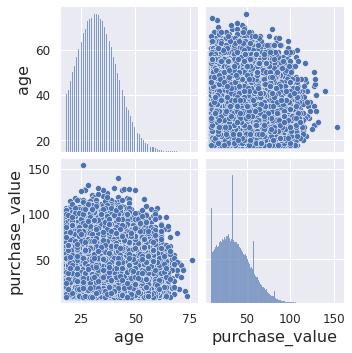

In [43]:
sns.pairplot(data=fraud_data[['age','purchase_value']])

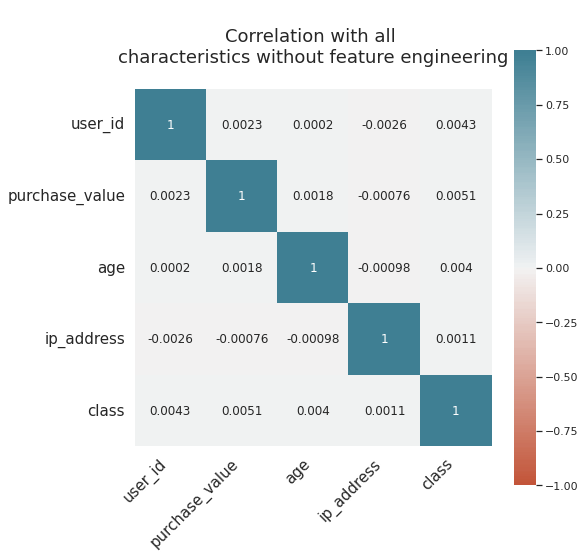

In [44]:
# correlation heat map of numerical features

sns.set()

numCol = []
for col in fraud_data:
  if fraud_data[col].dtype == 'float' or fraud_data[col].dtype == 'int':
    numCol.append(col)
corr = fraud_data[numCol].corr()

plt.figure(figsize =(8,8))
ax = sns.heatmap(
    corr, 
    annot = True,
    cbar = True,
    annot_kws={"size": 12},
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45, 
    horizontalalignment='right')

ax.set_yticklabels(
    ax.get_xticklabels(),
    rotation=360)

ax.set_title("\nCorrelation with all \ncharacteristics without feature engineering\n", size = 18)
ax.tick_params(labelsize = 15)

In [45]:
corr

,user_id,purchase_value,age,ip_address,class
user_id,1.000000,0.002262,0.000199,-0.002631,0.004279
purchase_value,0.002262,1.000000,0.001804,-0.000755,0.005138
age,0.000199,0.001804,1.000000,-0.000980,0.004006
ip_address,-0.002631,-0.000755,-0.000980,1.000000,0.001150
class,0.004279,0.005138,0.004006,0.001150,1.000000


There is no correlation between numerical features in fraud_data.

## Part 1.4 Outliers

In [46]:
fig = go.Figure()

x0 = fraud_data['age']
x1 = fraud_data['purchase_value']

fig.update_layout(title_text='Box plot of variables', width=800, height=600)
fig.add_trace(go.Box(x=x0, name= 'age'))
fig.add_trace(go.Box(x=x1, name= 'purchase_value'))
fig.update_xaxes(title_text="x-axis in logarithmic scale", type="log")

In [47]:
# go change the fig default setup
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 16,
         'axes.titlesize':'x-large',
         'xtick.labelsize':12,
         'ytick.labelsize':12}
pylab.rcParams.update(params)
plt.rc('font', size=14) 
plt.rc('legend', fontsize=12)

In [48]:
# Three sigma checking outlier
def outlier_check_3Sigma(df, cols):
  #for col in ['purchase_value', 'age']:
    mean = df[cols].mean()
    std = df[cols].std()
    low = mean - 3 * std
    high = mean + 3 * std
    df = df[((df > high) | (df < low)).any(axis=1)]
    return df

cols = ['purchase_value', 'age']
df_outliers_pd2 = outlier_check_3Sigma(fraud_data, cols)

print("There are total {} outlier data".format(len(df_outliers_pd2)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning:

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`



There are total 1303 outlier data


In [49]:
df_outliers_pd2.sort_values(['age', 'purchase_value'])

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
11537,191560,2015-01-10 19:02:54,2015-03-13 15:10:30,92,TZSHXHDMKLRYJ,Ads,FireFox,F,18,6.016662e+08,0
84646,378077,2015-05-07 11:58:22,2015-08-08 21:26:42,92,SSNHPSHAWWCAJ,Direct,IE,F,18,1.210864e+09,0
35650,363323,2015-06-16 16:06:57,2015-08-09 16:00:50,93,OGWBUMVGHBBWY,Ads,Chrome,M,18,1.042903e+09,0
...,...,...,...,...,...,...,...,...,...,...,...
23732,285428,2015-06-29 14:40:57,2015-08-30 01:57:59,15,MVEFIIBEKQLYM,SEO,FireFox,F,73,3.815763e+09,0
90447,129207,2015-01-19 06:21:59,2015-01-26 18:45:51,10,AXQKAVVVYNOYD,Direct,Safari,F,74,4.271295e+09,0
124590,136155,2015-03-08 06:49:53,2015-05-18 10:52:19,49,XZJCYGWPBAVYH,SEO,Chrome,F,76,2.386248e+09,0


After we went through the record which were isolated by outlier checker, we did not find any outlier values in these records, so we think there was no outlier found in fraud_data dataset.

# Part 2: Feature Engineering


## Part 2.1 Identify country info based on ip_address


In [50]:
ipToCountry.head(4)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia


In [51]:
# binary search for ip loaded country
start = time.time()

countries = []
for i in range(len(fraud_data)):
    ip_address = fraud_data.loc[i, 'ip_address']
    start = 0
    end = len(ipToCountry)
    while start < end:
      mid = start + (end - start) // 2
      if ipToCountry.loc[mid, 'lower_bound_ip_address'] <= ip_address <= ipToCountry.loc[mid, 'upper_bound_ip_address']:
        countries.append(ipToCountry.loc[mid, 'country'])
        break
      elif ip_address > ipToCountry.loc[mid, 'lower_bound_ip_address']:
        start = mid + 1
      else:
        end = mid
    if start >= end:
      countries.append('NA')
        
fraud_data['country'] = countries
runtime = time.time() - start 

print("Lookup took", runtime, "seconds.")

Lookup took 1661361546.5782928 seconds.


In [52]:
fraud_data.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada


In [53]:
fraud_data['country'].nunique()

181

In [54]:
fraud_data[fraud_data['country']=='NA'].shape

(20291, 12)

In [55]:
# check total country in fraud dataset
country_fraud = fraud_data[fraud_data['class']==1].groupby(['country']).size().reset_index(name='count')
country_fraud['percent'] = (country_fraud['count'] / sum(country_fraud['count']))*100
country_fraud = country_fraud.sort_values(by=['percent'], ascending=False)
country_fraud.shape

(70, 3)

In [56]:
# print country name
country_fraud['country'].unique()

array(['United States', 'NA', 'China', 'Japan', 'United Kingdom',
       'France', 'Korea Republic of', 'Canada', 'Germany', 'Brazil',
       'India', 'Mexico', 'Italy', 'Australia', 'Sweden', 'Argentina',
       'Norway', 'New Zealand', 'Netherlands', 'Russian Federation',
       'Turkey', 'Hong Kong', 'Spain', 'Belgium', 'Ireland',
       'South Africa', 'Egypt', 'Indonesia', 'Peru',
       'Taiwan; Republic of China (ROC)', 'Denmark',
       'United Arab Emirates', 'Colombia', 'Austria', 'Greece', 'Poland',
       'Saudi Arabia', 'Switzerland', 'Finland', 'Tunisia', 'Chile',
       'Venezuela', 'Romania', 'Luxembourg', 'Viet Nam', 'Ecuador',
       'Lithuania', 'Israel', 'Iran (ISLAMIC Republic Of)',
       'Czech Republic', 'Hungary', 'Seychelles', 'Sri Lanka', 'Belarus',
       'Uzbekistan', 'Uruguay', 'Bolivia', 'Costa Rica',
       'Croatia (LOCAL Name: Hrvatska)', 'Ukraine', 'Paraguay',
       'Thailand', 'Estonia', 'Panama', 'Kazakhstan', 'Slovenia',
       'Nigeria', 'Pakista

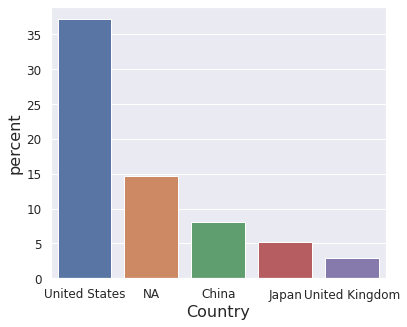

In [57]:
# Fig showing the total number of purchase according to source.
plt.figure(figsize = (6,5))
country_fraud_per = sns.barplot(x = 'country', y='percent', data = country_fraud.iloc[:5,:])
_ = country_fraud_per.set(xlabel="Country")

We employed the binary search to identify the country by looking at the ip_address from ipToCountry dataset, and then drop 'ip_address' from fraud dataset.

Summary of fraud and countries:

* There are total 180 countries in the fraud dataset, in which fraud was found in 79 countries.
* There are 20291 records in which country was marked with 'NA'. 
* The top 3 countries that fraud coming from include United States, China, Japan.

Feature Engineering(What types of features can we use?)

Q: How to check if column user_id is unique(no dup) for time related aggregates?

## Part 2.2 Generating new features

In [58]:
# deep copy fraud data
fraud_data1 = fraud_data.copy(deep= True)

In [59]:
print(fraud_data1.user_id.nunique())#138376
print(len(fraud_data1.index))#138376

138376
138376


In [60]:
fraud_data1.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada


All of the user_id has only the first 1 transaction.

In [61]:
#time related features: can be done before split, as they has no interaction between other rows, solely based on other columns of the same row
fraud_data1['interval_after_signup'] = (pd.to_datetime(fraud_data1['purchase_time']) - pd.to_datetime(
        fraud_data1['signup_time'])).dt.total_seconds()

fraud_data1['signup_days_of_year'] = pd.DatetimeIndex(fraud_data1['signup_time']).dayofyear

#bed time operation
fraud_data1['signup_seconds_of_day'] = pd.DatetimeIndex(fraud_data1['signup_time']).second + 60 * pd.DatetimeIndex(
    fraud_data1['signup_time']).minute + 3600 * pd.DatetimeIndex(fraud_data1['signup_time']).hour

fraud_data1['purchase_days_of_year'] = pd.DatetimeIndex(fraud_data1['purchase_time']).dayofyear
fraud_data1['purchase_seconds_of_day'] = pd.DatetimeIndex(fraud_data1['purchase_time']).second + 60 * pd.DatetimeIndex(
    fraud_data1['purchase_time']).minute + 3600 * pd.DatetimeIndex(fraud_data1['purchase_time']).hour

fraud_data1 = fraud_data1.drop(['user_id','signup_time','purchase_time'], axis=1)

In [62]:
fraud_data1.head()

,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
0,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,55,82549,108,10031
1,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,158,74390,159,5934
2,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,492085.0,118,76405,124,50090
3,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,202,25792,252,67253
4,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,4240931.0,141,21783,190,29114


In [63]:
fraud_data1.describe()

,purchase_value,age,ip_address,class,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
count,138376.000000,138376.000000,1.383760e+05,138376.000000,1.383760e+05,138376.000000,138376.000000,138376.000000,138376.000000
mean,36.938985,33.125867,2.154381e+09,0.010226,5.164377e+06,114.412449,43131.536733,174.183991,43247.600191
std,18.321091,8.623645,1.250563e+09,0.100605,3.004642e+06,66.389783,24949.850767,75.410596,24935.829856
...,...,...,...,...,...,...,...,...,...
50%,35.000000,33.000000,2.156471e+09,0.000000,5.165848e+06,114.000000,43216.000000,174.000000,43335.500000
75%,49.000000,39.000000,3.249150e+09,0.000000,7.768159e+06,172.000000,64676.000000,232.000000,64776.750000
max,154.000000,76.000000,4.294850e+09,1.000000,1.036797e+07,230.000000,86398.000000,350.000000,86399.000000


Summary of feature engineering:

* We generate interval_after_signup, signup_days_of_year, singup_seconds_of_day, purchase_days_of_year, purchase_seconds_of_day for the fraud dataset.
* We dropped user_id, signup_time, purchase_time.

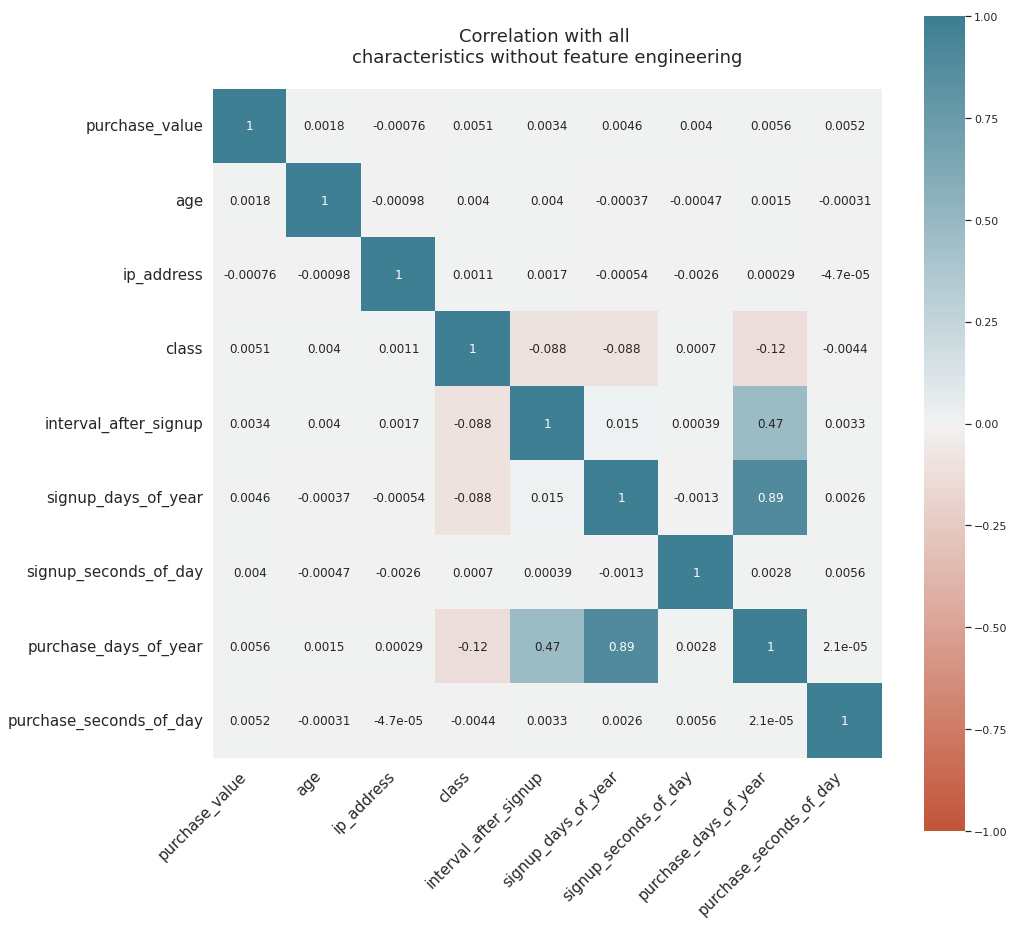

In [64]:
# correlation heat map of numerical features

sns.set()

numCol = []
for col in fraud_data1:
  if fraud_data1[col].dtype == 'float' or fraud_data1[col].dtype == 'int':
    numCol.append(col)
corr = fraud_data1[numCol].corr()

plt.figure(figsize =(15,15))
ax = sns.heatmap(
    corr, 
    annot = True,
    cbar = True,
    annot_kws={"size": 12},
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45, 
    horizontalalignment='right')

ax.set_yticklabels(
    ax.get_xticklabels(),
    rotation=360)

ax.set_title("\nCorrelation with all \ncharacteristics without feature engineering\n", size = 18)
ax.tick_params(labelsize = 15)

Since we generate new features, we rechecked the correlation of all numerical features, and found strong correlation between purchase_days_of_year and signup_days_of_year.

# Part 3: Data Split

In [65]:
# use class as output
y = fraud_data1['class']
X = fraud_data1.drop(['class'], axis=1)

#split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (110700, 13)
y_train.shape: (110700,)


In [66]:
X_train['country'].value_counts(ascending=True)
#drawback: collision in the same bucket(no differentiation for these countries)
# why some IP not country

Benin                1
Yemen                1
Fiji                 1
                 ...  
China             8876
NA               16275
United States    42348
Name: country, Length: 177, dtype: int64

Split summary:

* We used the class as output. 
* We splitteded date with 80% records for training, and 20% records for testing.

## Part 2.3: Feature Engineering


### Part 2.3.1: Converting categorical features with high cadinality to numericals

In [67]:
X_train_device_id_mapping = X_train.device_id.value_counts(dropna=False)
X_train_device_id_mapping


QTXDJHIIXYVQN    6
LQXZGPLMKAJJV    5
VSMNAOFPSEQOL    5
                ..
RCZGGVLPNZPXG    1
TLUDXYOENHBNL    1
AKABBOYHUDIAP    1
Name: device_id, Length: 107963, dtype: int64

In [68]:
X_train.head()

,purchase_value,device_id,source,browser,sex,age,ip_address,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
29343,12,OULPAZAFRFPXP,Ads,Chrome,M,42,3.690922e+09,Korea Republic of,3499664.0,183,67384,224,24648
12190,10,AIIWMFEYQQIEB,Ads,Opera,M,29,1.686759e+09,United States,6766039.0,5,78146,84,18585
19388,34,VUVETBUPCIWJE,Direct,Chrome,M,53,4.138429e+09,NA,5870515.0,197,81354,265,76669
89104,48,QCFULAJOYKFUU,Ads,Chrome,M,29,9.617337e+07,France,2145618.0,160,30920,185,16538
82082,44,IHRWLMIJMEEEU,Ads,FireFox,M,24,1.936025e+09,China,7079059.0,111,71897,193,66156


In [69]:
# use get_dummy to encode gender
X_train = pd.get_dummies(X_train, columns=['source', 'browser'])
X_train['sex'] = (X_train.sex == 'M').astype(int)

X_test = pd.get_dummies(X_test, columns=['source', 'browser'])
X_test['sex'] = (X_test.sex == 'M').astype(int)

In [70]:
X_train.head(20)

,purchase_value,device_id,sex,age,ip_address,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari
29343,12,OULPAZAFRFPXP,1,42,3.690922e+09,Korea Republic of,3499664.0,183,67384,224,24648,1,0,0,1,0,0,0,0
12190,10,AIIWMFEYQQIEB,1,29,1.686759e+09,United States,6766039.0,5,78146,84,18585,1,0,0,0,0,0,1,0
19388,34,VUVETBUPCIWJE,1,53,4.138429e+09,NA,5870515.0,197,81354,265,76669,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40048,11,CSXDFTWBSVKIH,1,27,3.615628e+09,United States,3777778.0,72,18835,115,81413,0,0,1,0,0,1,0,0
105255,19,BJSCTIKHMXWVX,1,33,2.806896e+09,United States,4258595.0,147,14867,196,39862,0,0,1,0,0,0,0,1
77134,38,UDZZUMOMQBRAT,0,33,4.114024e+09,NA,4139161.0,211,82174,259,74135,0,0,1,0,0,1,0,0


In [71]:
!pip install category-encoders
from category_encoders.target_encoder import TargetEncoder


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.0 MB/s 


In [72]:
# target encoder
target_enc = TargetEncoder(cols=['device_id', 'ip_address', 'country'])
target_enc.fit(X_train[['device_id', 'ip_address', 'country']], y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:94: FutureWarning:

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:99: FutureWarning:

Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327



TargetEncoder(cols=['device_id', 'ip_address', 'country'])

In [73]:
X_train[['device_id', 'ip_address', 'country']] = target_enc.transform(X_train[['device_id', 'ip_address', 'country']])

In [74]:
X_test[['device_id', 'ip_address', 'country']] = target_enc.transform(X_test[['device_id', 'ip_address', 'country']])

In [75]:
X_train.head()

,purchase_value,device_id,sex,age,ip_address,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari
29343,12,0.01019,1,42,0.01019,0.009106,3499664.0,183,67384,224,24648,1,0,0,1,0,0,0,0
12190,10,0.01019,1,29,0.01019,0.009776,6766039.0,5,78146,84,18585,1,0,0,0,0,0,1,0
19388,34,0.01019,1,53,0.01019,0.010507,5870515.0,197,81354,265,76669,0,1,0,1,0,0,0,0
89104,48,0.01019,1,29,0.01019,0.012489,2145618.0,160,30920,185,16538,1,0,0,1,0,0,0,0
82082,44,0.01019,1,24,0.01019,0.011041,7079059.0,111,71897,193,66156,1,0,0,0,1,0,0,0


In [76]:
X_test.head()

,purchase_value,device_id,sex,age,ip_address,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari
10224,19,0.01019,1,34,0.01019,0.010507,4311302.0,190,36985,240,28287,1,0,0,0,0,0,0,1
85132,31,0.01019,0,41,0.01019,0.010507,4079557.0,75,48284,122,67041,1,0,0,1,0,0,0,0
45717,29,0.01019,1,30,0.01019,0.010401,6104979.0,58,68033,129,38612,1,0,0,1,0,0,0,0
62898,74,0.01019,0,27,0.01019,0.009776,5206591.0,135,42763,195,65354,0,0,1,0,0,1,0,0
6553,39,0.01019,0,35,0.01019,0.010093,292543.0,201,59280,205,6223,0,1,0,0,0,1,0,0


Summary for feature generation:
* We employed the get_dummy method to encode the sex column.
* We employed target encoding to encode device_id, ip_address, and country.
* We seperately generated features in train and test data to avoid info leak. 

Q: What is the difference between normalization and standardization?

### Part 2.3.2: Normalizaiton of numerical featrues

In [77]:

#Compute the train minimum and maximum to be used for later scaling:
scaler = preprocessing.MinMaxScaler().fit(X_train[['device_id','ip_address', 'country', ]]) 

#transform the training data and use them for the model training
X_train[['device_id','ip_address', 'country']] = scaler.transform(X_train[['device_id','ip_address', 'country']])

#before the prediction of the test data, apply the same scaler obtained from above, on X_test, not fitting a brandnew scaler on test
X_test[['device_id','ip_address', 'country']] = scaler.transform(X_test[['device_id','ip_address', 'country']])



Summary of normalization:

* We used MinMaxScaler to normalize device_id, ip_address, country.

# Part 4: Model Evaluation and Selection


## Part 4.1: Model training with original data

In [78]:
# Logistic Regression
classifier_logistic = LogisticRegression()

# Random Forest
classifier_RF = RandomForestClassifier()

# AdaBoostClassifier
classifier_ABC = AdaBoostClassifier()

# GradientBoostingClassifier
classifier_GBC = GradientBoostingClassifier()

# XGBoost
classifier_XGB = XGBClassifier()

In [79]:
# UDF for model training and result printing

model_names = ['Logistic Regression','Random Forest', 'AdaBoost', 'GradientBoost', 'XGBooster']
model_list = [classifier_logistic, classifier_RF, classifier_ABC, classifier_GBC, classifier_XGB]

def model_selection(model_names, model_list, X_trian, X_test, y_trian, y_test):
    
    count = 0
    for classifier in model_list:

        # fit the model with data
        %time
        classifier.fit(X_train,y_train)

        # generate class probabilities
        predicted = classifier.predict(X_test)
        probs = classifier.predict_proba(X_test)

        # predict class labels 0/1 for the test set
        print("Summary for ", model_names[count])
        print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))
        print("%s: %r" % ("f1_score is: ", f1_score(y_test, predicted )))#string to int

        print ("confusion_matrix is: ")
        cm = confusion_matrix(y_test, predicted)
        cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
        print(cmDF)
        print('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
        print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0predicted = classifier_RF.predict(X_test)

        # generate evaluation metrics
        print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, predicted)), "\n\n")

        count += 1

In [92]:
model_selection(model_names, model_list, X_train, X_test, y_train, y_test)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs
Summary for  Logistic Regression
roc_auc_score is: : 0.7505929222329522
f1_score is: : 0.0
confusion_matrix is: 
        pred_0  pred_1
true_0   27389       0
true_1     287       0
recall = 0.0
precision = nan
accuracy_score is: : 0.9896300043358867 


CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 9.3 µs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning:

invalid value encountered in true_divide



Summary for  Random Forest
roc_auc_score is: : 0.7633951828113807
f1_score is: : 0.6697459584295612
confusion_matrix is: 
        pred_0  pred_1
true_0   27388       1
true_1     142     145
recall = 0.5052264808362369
precision = 0.9931506849315068
accuracy_score is: : 0.9948330683624801 


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Summary for  AdaBoost
roc_auc_score is: : 0.7563707574558468
f1_score is: : 0.6682134570765662
confusion_matrix is: 
        pred_0  pred_1
true_0   27389       0
true_1     143     144
recall = 0.5017421602787456
precision = 1.0
accuracy_score is: : 0.9948330683624801 


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs
Summary for  GradientBoost
roc_auc_score is: : 0.7598443918646349
f1_score is: : 0.6070686070686071
confusion_matrix is: 
        pred_0  pred_1
true_0   27341      48
true_1     141     146
recall = 0.5087108013937283
precision = 0.7525773195876289
accuracy_score is: : 0.9931709784650962 


CPU times: us

Summary of model training with original data:

* We trained logistic regression, random forest, adb boost, gradient boost, and XGBoost classifier.
* With default setting in differnt models, XGBoost has similar performance.

## Part 4.2: Model training after SMOTE

In [81]:
# upsample with SMOTE
smote = SMOTE(random_state=12)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train) 

unique, counts = np.unique(y_train_sm, return_counts=True)

print(np.asarray((unique, counts)).T)

[[     0 109572]
 [     1 109572]]


In [82]:
# repeat model selection after sample SMOTE
model_selection(model_names, model_list, X_train_sm, X_test, y_train_sm, y_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs
Summary for  Logistic Regression
roc_auc_score is: : 0.7505929222329522
f1_score is: : 0.0
confusion_matrix is: 
        pred_0  pred_1
true_0   27389       0
true_1     287       0
recall = 0.0
precision = nan
accuracy_score is: : 0.9896300043358867 


CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 8.34 µs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning:

invalid value encountered in true_divide



Summary for  Random Forest
roc_auc_score is: : 0.7721986611018972
f1_score is: : 0.6666666666666665
confusion_matrix is: 
        pred_0  pred_1
true_0   27388       1
true_1     143     144
recall = 0.5017421602787456
precision = 0.993103448275862
accuracy_score is: : 0.9947969359734066 


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs
Summary for  AdaBoost
roc_auc_score is: : 0.7563707574558468
f1_score is: : 0.6682134570765662
confusion_matrix is: 
        pred_0  pred_1
true_0   27389       0
true_1     143     144
recall = 0.5017421602787456
precision = 1.0
accuracy_score is: : 0.9948330683624801 


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs
Summary for  GradientBoost
roc_auc_score is: : 0.7598934972622469
f1_score is: : 0.6083333333333334
confusion_matrix is: 
        pred_0  pred_1
true_0   27342      47
true_1     141     146
recall = 0.5087108013937283
precision = 0.7564766839378239
accuracy_score is: : 0.9932071108541697 


CPU times: use

Summary of training after SMOTE:

SMOTE does not imporve the model performance with RF and XGBoost. Thereforet, we continued the following analysis with the dataset without SMOTE.

In [83]:
####

# Part 5: Hyper-parameter Tuning for XGBoost

## UDF for hyper-parameter tuning and model evaluation

In [84]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score, pos_label=1)
    
}

In [85]:
def grid_search_wrapper(model, parameters, refit_score='f1_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    prints classifier performance metrics
    """

    grid_search = GridSearchCV(model, parameters, scoring=scorers, refit=refit_score,
                           cv=5, return_train_score=True)
    grid_search.fit(X_train_sm, y_train_sm)

    # make the predictions
    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1]
    
    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of {} optimized for {} on the test data:'.format(model, refit_score))
    cm = confusion_matrix(y_test, y_pred)
    (_, _, f1, _) = metrics.precision_recall_fscore_support(y_test, y_pred,
                                                        average='weighted', 
                                                        warn_for=tuple())
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)
    
    print("\t%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, y_prob)))
    print("\t%s: %r" % ("f1_score is: ", f1_score(y_test, y_pred)))#string to int

    print('recall = ', float(cm[1,1]) / (cm[1,0] + cm[1,1]))
    print('precision = ', float(cm[1,1]) / (cm[1, 1] + cm[0,1]))

    return grid_search



In [86]:
# learning curve
def learning_curve_drawing(model, X_train, y_train):
    train_sizes, train_scores, test_scores = \
                    learning_curve(estimator = model,
                                  X=X_train,
                                  y=y_train,
                                  train_sizes=np.linspace(0.1, 1.0, 10),
                                  cv=10,
                                  n_jobs=1)
                    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, train_mean,
            color='blue', marker='o',
            markersize=5, label='training accuracy')
    plt.fill_between(train_sizes,
                    train_mean + train_std,
                    train_mean - train_std,
                    alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean,
            color='green', linestyle='--',
            marker='s', markersize=5,
            label='validation accuracy')
    plt.fill_between(train_sizes,
                    test_mean + test_std,
                    test_mean - test_std,
                    alpha=0.15, color='green')

    plt.rc('figure', figsize=(8, 4))
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

In [87]:
# roc_auc curve
def roc_auc_fig_score(model, X_test, y_test, model_name):
    y_pred_model = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_model)
    print(metrics.auc(fpr, tpr))
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=model_name)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve - RF model')
    plt.legend(loc='best')
    plt.show()

## Part 5.1: Hyper-parameter tuning based on best F1_score

We first used F1 score as creterior for hyper-parameter tuning.

In [88]:
#parameters = {        
              #'max_depth': [None, 5, 10],
              #'n_estimators' :  [50, 100, 150], 
              #'class_weight' : [{0: 1, 1: w} for w in [0.2, 1, 10]]
              #}

#clf = RandomForestClassifier(random_state=0)

In [93]:
parameters = {        
        'min_child_weight': [0.5, 1, 5],
        'subsample': [0.25, 0.5, 1.0],
        'max_depth': [5, 6, 7]
}

clf =XGBClassifier(random_state=0)

In [94]:
grid_search_xgb_f1 = grid_search_wrapper(clf, parameters, refit_score='f1_score')

Best params for f1_score
{'max_depth': 7, 'min_child_weight': 0.5, 'subsample': 0.5}

Confusion matrix of XGBClassifier() optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27387       2
true_1     142     145
	roc_auc_score is: : 0.7531298012134631
	f1_score is: : 0.6682027649769584
recall =  0.5052264808362369
precision =  0.9863945578231292


In [95]:
best_xgb_model_f1 = grid_search_xgb_f1.best_estimator_
print('Parameters currently in used:\n')
print(best_xgb_model_f1.get_params())

Parameters currently in used:

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 0.5, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.5, 'verbosity': 1}


In [96]:
#learning_curve_drawing(RandomForestClassifier(n_estimators = 50, max_depth = None, class_weight = {0: 1, 1: 0.2}, random_state = 0), X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



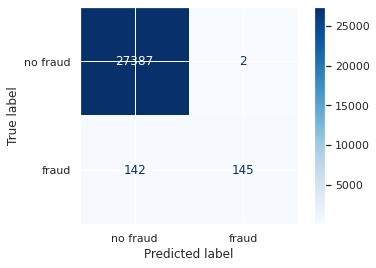

In [97]:
plot_confusion_matrix(best_xgb_model_f1, X_test, y_test,
                      display_labels=["no fraud","fraud"],cmap=plt.cm.Blues)

0.7531298012134631


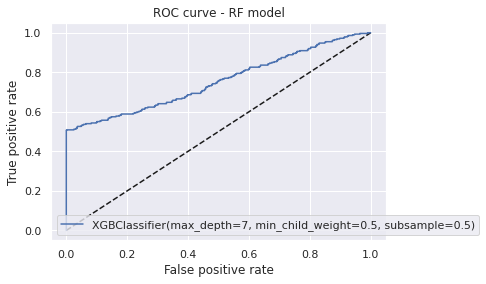

In [98]:
roc_auc_fig_score(best_xgb_model_f1, X_test, y_test, best_xgb_model_f1)

In [99]:
results_xgb_f1 = pd.DataFrame(grid_search_xgb_f1.cv_results_)
results_xgb_sortf1 = results_xgb_f1.sort_values(by='mean_test_f1_score', ascending=False)
results_xgb_sortf1[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score','param_max_depth', 'param_min_child_weight', 'param_subsample']].round(3).head()


,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,mean_train_precision_score,mean_train_recall_score,mean_train_f1_score,param_max_depth,param_min_child_weight,param_subsample
19,0.999,0.989,0.994,1.000,0.991,0.995,7,0.5,0.5
22,0.999,0.989,0.994,1.000,0.990,0.995,7,1,0.5
18,0.999,0.988,0.993,0.999,0.990,0.995,7,0.5,0.25
20,0.999,0.988,0.993,1.000,0.990,0.995,7,0.5,1.0
26,0.999,0.988,0.993,1.000,0.989,0.994,7,5,1.0


## Part 5.2: Hyper-parameter tuning based on best recall_score

We first used recall score as creterior for hyper-parameter tuning.

In [100]:
grid_search_xgb_recall = grid_search_wrapper(clf, parameters, refit_score='recall_score')

Best params for recall_score
{'max_depth': 7, 'min_child_weight': 0.5, 'subsample': 0.5}

Confusion matrix of XGBClassifier() optimized for recall_score on the test data:
        pred_0  pred_1
true_0   27387       2
true_1     142     145
	roc_auc_score is: : 0.7531298012134631
	f1_score is: : 0.6682027649769584
recall =  0.5052264808362369
precision =  0.9863945578231292


In [101]:
best_xgb_model_recall = grid_search_xgb_recall.best_estimator_
best_xgb_model_recall

XGBClassifier(max_depth=7, min_child_weight=0.5, subsample=0.5)

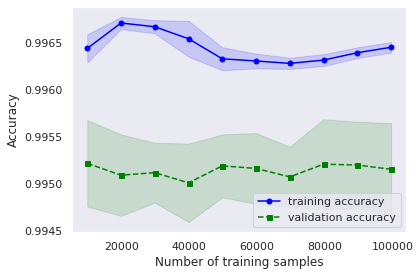

In [102]:
learning_curve_drawing(best_xgb_model_recall, X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



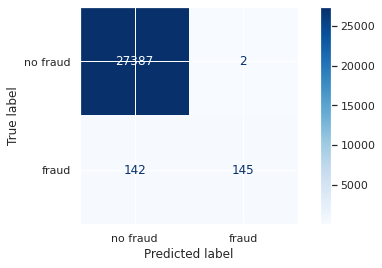

In [103]:
plot_confusion_matrix(best_xgb_model_recall, X_test, y_test,
                      display_labels=["no fraud","fraud"],cmap=plt.cm.Blues)

0.7531298012134631


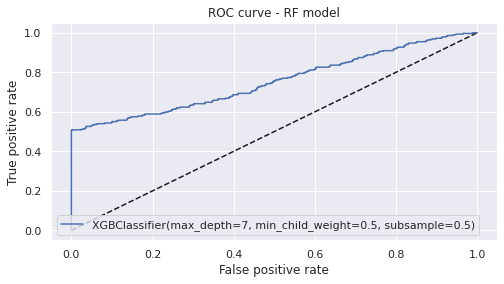

In [104]:
roc_auc_fig_score(best_xgb_model_recall, X_test, y_test, best_xgb_model_recall)

In [105]:
# predict class labels for the test set
predictedBest_recall = best_xgb_model_recall.predict(X_test)

# generate class probabilities
probsBest_recall = best_xgb_model_recall.predict_proba(X_test)

results_recall = pd.DataFrame(grid_search_xgb_recall.cv_results_)# recall score is different from above, as above is metric on test data, this is performance on cv data
results_sortrecall = results_recall.sort_values(by='mean_test_recall_score', ascending=False)
results_sortrecall[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score','param_max_depth', 'param_min_child_weight', 'param_subsample']].round(3).head()
#recall is worse than default rf?? no this is on test, but train recall is better

,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,mean_train_precision_score,mean_train_recall_score,mean_train_f1_score,param_max_depth,param_min_child_weight,param_subsample
19,0.999,0.989,0.994,1.000,0.991,0.995,7,0.5,0.5
22,0.999,0.989,0.994,1.000,0.990,0.995,7,1,0.5
18,0.999,0.988,0.993,0.999,0.990,0.995,7,0.5,0.25
20,0.999,0.988,0.993,1.000,0.990,0.995,7,0.5,1.0
21,0.999,0.988,0.993,0.999,0.990,0.994,7,1,0.25


Summary of hyper-parameter tuning for RandomForestClassifier:

* We conducted grid search for hyper parameter tuning.
* After the hyperparameter tuning, we found that there is no improvement with the model performance, compared with default setting of random forest. Therefore, we used default RandomForestClassifier for further analysis.
* We also found that recall was not a good creterior used in this case for fraud prediction.

## Part 5.3: Train the final RandomForestClassifier

In [107]:
xgb_model = XGBClassifier().fit(X_train, y_train)

# Part 6: Model Evaluation and Fraud Characteristics

In [108]:
#Var Importance
top_key_features_xgb = pd.DataFrame(xgb_model.feature_importances_, index = X_train.columns, columns=['xgb_feature_importance']).sort_values('xgb_feature_importance', ascending=False)
top_key_features_xgb.head(5)

,xgb_feature_importance
interval_after_signup,0.613979
device_id,0.142041
ip_address,0.080729
purchase_days_of_year,0.026565
source_Direct,0.021119


In [109]:
from sklearn.inspection import permutation_importance
PI_xgb = permutation_importance(xgb_model, X_test, y_test, n_repeats = 5, random_state=1)

In [110]:
PI_res = pd.DataFrame(data=np.transpose([PI_xgb['importances_mean'],PI_xgb['importances_std']]), 
             index = X_test.columns,columns=['PI_mean','PI_std'])
PI_res = PI_res.sort_values(by='PI_mean',ascending=False)
PI_res.head(5)

,PI_mean,PI_std
interval_after_signup,0.010392,0.000071
device_id,0.000448,0.000078
purchase_days_of_year,0.000022,0.000018
purchase_seconds_of_day,0.000014,0.000018
signup_days_of_year,0.000007,0.000014


In [111]:
fraud_data1[fraud_data1['class'] == 1].head(100)

,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
136961,24,VLHGCDPFCICDA,SEO,Chrome,F,33,3.432126e+09,1,United States,3327952.0,218,80113,257,38465
136962,14,YLUQSRNYYIPXU,Ads,Chrome,M,40,3.905319e+09,1,NA,1.0,12,4207,12,4208
136963,63,ABUBCQDATQMQH,Ads,FireFox,F,46,5.505670e+08,1,United States,7640070.0,49,40723,137,77593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137058,54,XHZBVWFWHSGTQ,SEO,FireFox,M,50,2.249217e+09,1,United States,1.0,1,32483,1,32484
137059,10,WETYPHOQVLWMK,Ads,FireFox,M,36,2.293333e+09,1,United States,1.0,7,63914,7,63915
137060,69,UWEPEOUQYEPZF,Direct,Chrome,M,36,2.534293e+09,1,Italy,1.0,8,41850,8,41851


In [112]:
trainDF = pd.concat([X_train, y_train], axis=1)
dev_shared_ct = pd.crosstab(trainDF["device_id"],trainDF["class"])
dev_shared_ct['fraud_rate'] = dev_shared_ct.iloc[:,1]/dev_shared_ct.iloc[:,0]
dev_shared_ct.sort_values(by = ['fraud_rate'])

class,0,1,fraud_rate
device_id,,,
0.000000,63,0,0.000000
0.001603,4088,0,0.000000
0.009429,104966,461,0.004392
...,...,...,...
0.769649,0,56,inf
0.925360,0,15,inf
1.000000,0,4,inf


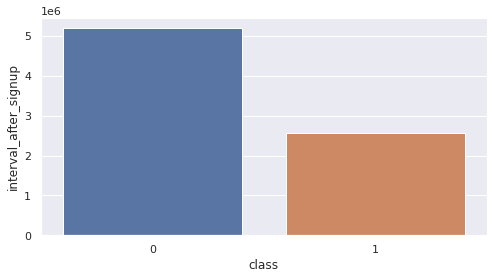

In [113]:
a = fraud_data1.groupby("class")[['interval_after_signup']].mean().reset_index()#action velocity(consecutive operations/actions of user)
#interval_after_signup on frauds are significantly lower compared to legits
a = pd.DataFrame(a)
a.rename(columns={'class': 'class', 'interval_after_signup':'interval_after_signup'}, inplace = True)
sns.barplot(x='class', y= 'interval_after_signup', data = a)

In [114]:
interval_signup = fraud_data1.groupby("class")[['interval_after_signup']].median()#1
#more than half of fraud happened 1s after signed up

In [115]:
interval_signup_df = pd.DataFrame(interval_signup)
interval_signup_df.add_suffix("_num").reset_index()

,class,interval_after_signup_num
0,0,5194911.0
1,1,1.0


In [116]:
interval_signup_df.columns

Index(['interval_after_signup'], dtype='object')

In [117]:
fraud_data1.groupby("class")[['purchase_days_of_year']].mean()

,purchase_days_of_year
class,
0,175.089960
1,86.493286


In [118]:
fraud_data1.groupby("class")[['purchase_days_of_year']].median()

,purchase_days_of_year
class,
0,175.0
1,12.0


Summary:

* Device id, interval after signup, and purchase days of year are top features of fraud purchases.
* Purchases with 1s interval after signup is a strong sign for fraud.

# Part 7: Model Implementation

In [119]:
t = (10 * probsBest_recall[:, 1]).astype(int)
unique, counts = np.unique(t, return_counts=True)

print(np.asarray((unique, counts)).T)



[[    0 27196]
 [    1   275]
 [    2    41]
 [    3    11]
 [    4     6]
 [    5     1]
 [    7     1]
 [    8    15]
 [    9   130]]


Recommendation:

* We marked the purchases with different possibilities (1 - 10) of fraud.
* Purchases marked with red (8 to 9) should be directely declined.
* Purchases mareked with green (1 to 3) is safe.
* Purchases mareked with grey (4 to 7) need manual investigation. 